In [ ]:
!git clone https://github.com/DanteMillerDS/Classifying-Patient-Phenotypes.git
%cd Classifying-Patient-Phenotypes
!git submodule init
!git submodule update
%cd ..

Cloning into 'Classifying-Patient-Phenotypes'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 326 bytes | 326.00 KiB/s, done.
/content/Classifying-Patient-Phenotypes
Submodule 'mimic3-benchmarks' (https://github.com/syfantid/mimic3-benchmarks.git) registered for path 'mimic3-benchmarks'
Cloning into '/content/Classifying-Patient-Phenotypes/mimic3-benchmarks'...
Submodule path 'mimic3-benchmarks': checked out 'eccce8a8db2e99b69746003f0e09c8219adf5dd4'
/content


In [ ]:
!wget -r -N -c -np --user dantemillerds --ask-password https://physionet.org/files/mimiciii/1.4/
%cd physionet.org/files/mimiciii/1.4/
!find . -name '*.csv.gz' -exec gzip -d {} \;
%cd ../../../../
%mv physionet.org Classifying-Patient-Phenotypes/
%cd Classifying-Patient-Phenotypes/
%cd mimic3-benchmarks

Password for user ‘dantemillerds’: 
--2023-04-23 15:18:38--  https://physionet.org/files/mimiciii/1.4/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="PhysioNet", charset="UTF-8"
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/mimiciii/1.4/index.html’

physionet.org/files     [ <=>                ]   3.68K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-04-23 15:18:39 (288 MB/s) - ‘physionet.org/files/mimiciii/1.4/index.html’ saved [3770]

Loading robots.txt; please ignore errors.
--2023-04-23 15:18:39--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving

In [ ]:
with open("mimic3benchmark/preprocessing.py", "r+") as f:
    content = f.readlines()
    f.seek(0, 0)
    for line in content:
        f.write(line)
        if line == "from __future__ import print_function\n":
            f.write("import warnings\n")
            f.write("warnings.filterwarnings(\"ignore\")\n")

In [ ]:
!python -m mimic3benchmark.scripts.extract_subjects ../physionet.org/files/mimiciii/1.4/ data/root/

START:
	ICUSTAY_IDs: 61532
	HADM_IDs: 57786
	SUBJECT_IDs: 46476
REMOVE ICU TRANSFERS:
	ICUSTAY_IDs: 55830
	HADM_IDs: 52834
	SUBJECT_IDs: 43277
REMOVE MULTIPLE STAYS PER ADMIT:
	ICUSTAY_IDs: 50186
	HADM_IDs: 50186
	SUBJECT_IDs: 41587
REMOVE PATIENTS AGE < 18:
	ICUSTAY_IDs: 42276
	HADM_IDs: 42276
	SUBJECT_IDs: 33798
Breaking up stays by subjects: 100% 33798/33798 [01:04<00:00, 520.34it/s]
Breaking up diagnoses by subjects: 100% 33798/33798 [01:17<00:00, 438.68it/s]
Processing CHARTEVENTS table: 100% 330712483/330712484 [50:51<00:00, 108385.90it/s]
Processing LABEVENTS table: 100% 27854055/27854056 [04:23<00:00, 105819.55it/s]
Processing OUTPUTEVENTS table: 100% 4349218/4349219 [01:02<00:00, 69995.96it/s]


In [ ]:
!python -m mimic3benchmark.scripts.validate_events data/root/

Namespace(subjects_root_path='data/root/')
Iterating over subjects: 100% 33798/33798 [38:45<00:00, 14.53it/s]
n_events: 253116833
empty_hadm: 5162703
no_hadm_in_stay: 32266173
no_icustay: 15735688
recovered: 15735688
could_not_recover: 0
icustay_missing_in_stays: 7115720


In [ ]:
!python -m mimic3benchmark.scripts.extract_episodes_from_subjects data/root/

Iterating over subjects: 100% 33802/33802 [1:03:59<00:00,  8.80it/s]


In [ ]:
!python -m mimic3benchmark.scripts.split_train_and_test data/root/

In [ ]:
with open('mimic3benchmark/scripts/split_train_and_test.py', 'w') as file:
    file.seek(0)
    file.truncate()
    file.write('''from __future__ import absolute_import
from __future__ import print_function

import os
import shutil
import argparse


def move_to_partition(args, patients, partition):
    if not os.path.exists(os.path.join(args.subjects_root_path, partition)):
        os.mkdir(os.path.join(args.subjects_root_path, partition))
    for patient in patients:
        src = os.path.join(args.subjects_root_path, patient)
        dest = os.path.join(args.subjects_root_path, partition, patient)
        shutil.move(src, dest)


def main():
    parser = argparse.ArgumentParser(description='Split data into train and test sets.')
    parser.add_argument('subjects_root_path', type=str, help='Directory containing subject sub-directories.')
    args, _ = parser.parse_known_args()

    test_set = set()
    with open(os.path.join(os.path.dirname(__file__), '../resources/testset.csv'), "r") as test_set_file:
        for line in test_set_file:
            x, y = line.split(',')
            if int(y) == 1:
                test_set.add(x)

    folders = os.listdir(args.subjects_root_path)
    folders = list((filter(str.isdigit, folders)))
    train_patients = [x for x in folders if x not in test_set]
    test_patients = [x for x in folders if x in test_set]

    assert len(set(train_patients) & set(test_patients)) == 0

    try:
      move_to_partition(args, train_patients, "train")
      move_to_partition(args, test_patients, "test")
    except:
      None

if __name__ == '__main__':
    main()''')

In [ ]:
!python -m mimic3benchmark.scripts.create_phenotyping data/root/ data/phenotyping/

Iterating over patients in test:   0% 17/5070 [00:00<01:01, 81.92it/s]
	(no events in ICU)  62641 episode3_timeseries.csv
Iterating over patients in test:   2% 82/5070 [00:00<00:58, 84.56it/s]
	(no events in ICU)  10067 episode1_timeseries.csv
Iterating over patients in test:   3% 169/5070 [00:02<00:59, 82.54it/s]
	(no events in ICU)  8294 episode1_timeseries.csv
Iterating over patients in test:  21% 1073/5070 [00:13<00:49, 80.19it/s]
	(no events in ICU)  29129 episode2_timeseries.csv
Iterating over patients in test:  23% 1189/5070 [00:15<00:48, 80.52it/s]
	(no events in ICU)  14040 episode1_timeseries.csv
Iterating over patients in test:  42% 2110/5070 [00:26<00:39, 75.04it/s]
	(no events in ICU)  13072 episode1_timeseries.csv
Iterating over patients in test:  54% 2729/5070 [00:32<00:25, 92.54it/s]
	(no events in ICU)  11903 episode1_timeseries.csv
Iterating over patients in test:  62% 3119/5070 [00:36<00:19, 100.34it/s]
	(no events in ICU)  84418 episode1_timeseries.csv
Iterating ove

In [ ]:
with open('mimic3models/keras_models/lstm.py', 'w') as file:
    file.seek(0)
    file.truncate()
    file.write('''
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Masking, Dropout
from keras.layers import Bidirectional, TimeDistributed
from mimic3models.keras_utils import LastTimestep
from mimic3models.keras_utils import ExtendMask


class Network(Model):

    def __init__(self, dim, batch_norm, dropout, rec_dropout, task,
                 target_repl=False, deep_supervision=False, num_classes=1,
                 depth=1, input_dim=76, **kwargs):

        print("==> not used params in network class:", kwargs.keys())

        self.dim = dim
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.rec_dropout = rec_dropout
        self.depth = depth

        if task in ['decomp', 'ihm', 'ph']:
            final_activation = 'sigmoid'
        elif task in ['los']:
            if num_classes == 1:
                final_activation = 'relu'
            else:
                final_activation = 'softmax'
        else:
            raise ValueError("Wrong value for task")

        # Input layers and masking
        X = Input(shape=(None, input_dim), name='X')
        inputs = [X]
        mX = Masking()(X)

        if deep_supervision:
            M = Input(shape=(None,), name='M')
            inputs.append(M)

        # Configurations
        is_bidirectional = True
        if deep_supervision:
            is_bidirectional = False

        # Main part of the network
        for i in range(depth - 1):
            num_units = dim
            if is_bidirectional:
                num_units = num_units // 2

            lstm = LSTM(units=num_units,
                        activation='tanh',
                        return_sequences=True,
                        recurrent_dropout=rec_dropout,
                        dropout=dropout)

            if is_bidirectional:
                mX = Bidirectional(lstm)(mX)
            else:
                mX = lstm(mX)

        # Output module of the network
        return_sequences = (target_repl or deep_supervision)
        L = LSTM(units=dim,
                 activation='tanh',
                 return_sequences=return_sequences,
                 dropout=dropout,
                 recurrent_dropout=rec_dropout)(mX)

        if dropout > 0:
            L = Dropout(dropout)(L)

        if target_repl:
            y = TimeDistributed(Dense(num_classes, activation=final_activation),
                                name='seq')(L)
            y_last = LastTimestep(name='single')(y)
            outputs = [y_last, y]
        elif deep_supervision:
            y = TimeDistributed(Dense(num_classes, activation=final_activation))(L)
            y = ExtendMask()([y, M])  # this way we extend mask of y to M
            outputs = [y]
        else:
            y = Dense(num_classes, activation=final_activation)(L)
            outputs = [y]

        super(Network, self).__init__(inputs=inputs, outputs=outputs)

    def say_name(self):
        return "{}.n{}{}{}{}.dep{}".format('k_lstm',
                                           self.dim,
                                           ".bn" if self.batch_norm else "",
                                           ".d{}".format(self.dropout) if self.dropout > 0 else "",
                                           ".rd{}".format(self.rec_dropout) if self.rec_dropout > 0 else "",
                                           self.depth)
                                           ''')

In [ ]:
with open('mimic3models/phenotyping/main.py', 'w') as file:
    file.seek(0)
    file.truncate()
    file.write('''
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import argparse
import os
import imp
import pandas as pd
import re
import keras
from mimic3models.phenotyping import utils
from mimic3benchmark.readers import PhenotypingReader

from mimic3models.preprocessing import Discretizer, Normalizer
from mimic3models import metrics
from mimic3models import keras_utils
from mimic3models import common_utils

from keras.callbacks import ModelCheckpoint, CSVLogger

parser = argparse.ArgumentParser()
common_utils.add_common_arguments(parser)
parser.add_argument('--target_repl_coef', type=float, default=0.0)
parser.add_argument('--data', type=str, help='Path to the data of phenotyping task',
                    default=os.path.join(os.path.dirname(__file__), '../../data/phenotyping/'))
parser.add_argument('--output_dir', type=str, help='Directory relative which all output files are stored',
                    default='.')
args = parser.parse_args()
print(args)

if args.small_part:
    args.save_every = 2**30

target_repl = (args.target_repl_coef > 0.0 and args.mode == 'train')

# Build readers, discretizers, normalizers
train_reader = PhenotypingReader(dataset_dir=os.path.join(args.data, 'train'),
                                 listfile=os.path.join(args.data, 'train/listfile.csv'))

val_reader = PhenotypingReader(dataset_dir=os.path.join(args.data, 'test'),
                               listfile=os.path.join(args.data, 'test/listfile.csv'))

discretizer = Discretizer(timestep=float(args.timestep),
                          store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')

discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
normalizer_state = args.normalizer_state
if normalizer_state is None:
    normalizer_state = 'ph_ts{}.input_str_previous.start_time_zero.normalizer'.format(args.timestep)
    normalizer_state = os.path.join(os.path.dirname(__file__), normalizer_state)
normalizer.load_params(normalizer_state)

args_dict = dict(args._get_kwargs())
args_dict['header'] = discretizer_header
args_dict['task'] = 'ph'
args_dict['num_classes'] = 25
args_dict['target_repl'] = target_repl

# Build the model
print("==> using model {}".format(args.network))
model_module = imp.load_source(os.path.basename(args.network), args.network)
model = model_module.Network(**args_dict)
suffix = ".bs{}{}{}.ts{}{}".format(args.batch_size,
                                   ".L1{}".format(args.l1) if args.l1 > 0 else "",
                                   ".L2{}".format(args.l2) if args.l2 > 0 else "",
                                   args.timestep,
                                   ".trc{}".format(args.target_repl_coef) if args.target_repl_coef > 0 else "")
model.final_name = args.prefix + model.say_name() + suffix
print("==> model.final_name:", model.final_name)


# Compile the model
print("==> compiling the model")
optimizer_config = keras.optimizers.Adam(learning_rate=args.lr,beta_1=args.beta_1)

# NOTE: one can use binary_crossentropy even for (B, T, C) shape.
#       It will calculate binary_crossentropies for each class
#       and then take the mean over axis=-1. Tre results is (B, T).
if target_repl:
    loss = ['binary_crossentropy'] * 2
    loss_weights = [1 - args.target_repl_coef, args.target_repl_coef]
else:
    loss = 'binary_crossentropy'
    loss_weights = None

model.compile(optimizer=optimizer_config,
              loss=loss,
              loss_weights=loss_weights)
model.summary()

# Load model weights
n_trained_chunks = 0
if args.load_state != "":
    model.load_weights(args.load_state)
    n_trained_chunks = int(re.match(".*epoch([0-9]+).*", args.load_state).group(1))


# Build data generators
train_data_gen = utils.BatchGen(train_reader, discretizer,
                                normalizer, args.batch_size,
                                args.small_part, target_repl, shuffle=True)
val_data_gen = utils.BatchGen(val_reader, discretizer,
                              normalizer, args.batch_size,
                              args.small_part, target_repl, shuffle=False)

if args.mode == 'train' or args.mode == 'both':
    # Prepare training
    path = os.path.join(args.output_dir, 'keras_states/' + model.final_name + '.epoch{epoch}.test{val_loss}.state')

    metrics_callback = keras_utils.PhenotypingMetrics(train_data_gen=train_data_gen,
                                                      val_data_gen=val_data_gen,
                                                      batch_size=args.batch_size,
                                                      verbose=args.verbose)
    # make sure save directory exists
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    saver = ModelCheckpoint(path, verbose=1, period=args.save_every)

    keras_logs = os.path.join(args.output_dir, 'keras_logs')
    if not os.path.exists(keras_logs):
        os.makedirs(keras_logs)
    csv_logger = CSVLogger(os.path.join(keras_logs, model.final_name + '.csv'),
                           append=True, separator=';')

    print("==> training")
    model.fit_generator(generator=train_data_gen,
                        steps_per_epoch=train_data_gen.steps,
                        validation_data=val_data_gen,
                        validation_steps=val_data_gen.steps,
                        epochs=0 + 10,
                        initial_epoch=0,
                        callbacks=[metrics_callback, saver, csv_logger],
                        verbose=1)
if args.mode == 'test' or args.mode == 'both':

    # ensure that the code uses test_reader
    del train_reader
    del val_reader
    del train_data_gen
    del val_data_gen

    train_reader = PhenotypingReader(dataset_dir=os.path.join(args.data, 'train'),
                                    listfile=os.path.join(args.data, 'train/listfile.csv'))

    train_data_gen = utils.BatchGen(train_reader, discretizer,
                                   normalizer, args.batch_size,
                                   args.small_part, target_repl,
                                   shuffle=False, return_names=True)
    print("Getting ready to make predictions...")
    names = []
    ts = []
    labels = []
    predictions = []
    for i in range(train_data_gen.steps):
        #print("predicting {} / {}".format(i, train_data_gen.steps), end="\\r")
        ret = next(train_data_gen)
        x = ret["data"][0]
        y = ret["data"][1]
        cur_names = ret["names"]
        cur_ts = ret["ts"]
        x = np.array(x)
        pred = model.predict_on_batch(x)
        predictions += list(pred)
        labels += list(y)
        names += list(cur_names)
        ts += list(cur_ts)
    print("Training Names")
    print(names[0:5])
    print("Training TS")
    print(ts[0:5])
    print("Training Labels")
    print(labels[0:5])
    print("Training Predictions")
    print(predictions[0:5])

    print("Saving Training Predictions...")
    n = len(names)
    data_dict_pred = {}
    data_dict_labels = {}
    for i in range(n):
        data_dict_pred[names[i]] = predictions[i]
        data_dict_labels[names[i]] = labels[i]
    df = pd.DataFrame(data_dict_pred)
    df = df.T.reset_index()
    df.to_csv('training_predictions.csv', index=False)
    df = pd.DataFrame(data_dict_labels)
    df = df.T.reset_index()
    df.to_csv('training_labels.csv', index=False)
    print("Finished Saving Training Predictions")


    metrics.print_metrics_multilabel(labels, predictions)
    path = os.path.join(args.output_dir, "train_predictions", os.path.basename(args.load_state)) + ".csv"
    utils.save_results(names, ts, predictions, labels, path)

if args.mode == 'test' or args.mode == 'both':

    # ensure that the code uses test_reader
    del train_reader
    del train_data_gen

    test_reader = PhenotypingReader(dataset_dir=os.path.join(args.data, 'test'),
                                    listfile=os.path.join(args.data, 'test/listfile.csv'))

    test_data_gen = utils.BatchGen(test_reader, discretizer,
                                   normalizer, args.batch_size,
                                   args.small_part, target_repl,
                                   shuffle=False, return_names=True)
    print("Getting ready to make predictions...")
    names = []
    ts = []
    labels = []
    predictions = []
    for i in range(test_data_gen.steps):
        #print("predicting {} / {}".format(i, test_data_gen.steps), end="\\r")
        ret = next(test_data_gen)
        x = ret["data"][0]
        y = ret["data"][1]
        cur_names = ret["names"]
        cur_ts = ret["ts"]
        x = np.array(x)
        pred = model.predict_on_batch(x)
        predictions += list(pred)
        labels += list(y)
        names += list(cur_names)
        ts += list(cur_ts)
    print("Testing Names")
    print(names[0:5])
    print("Testing TS")
    print(ts[0:5])
    print("Testing Labels")
    print(labels[0:5])
    print("Testing Predictions")
    print(predictions[0:5])

    print("Saving Testing Predictions...")
    n = len(names)
    data_dict_pred = {}
    data_dict_labels = {}
    for i in range(n):
        data_dict_pred[names[i]] = predictions[i]
        data_dict_labels[names[i]] = labels[i]
    df = pd.DataFrame(data_dict_pred)
    df = df.T.reset_index()
    df.to_csv('testing_predictions.csv', index=False)
    df = pd.DataFrame(data_dict_labels)
    df = df.T.reset_index()
    df.to_csv('testing_labels.csv', index=False)
    print("Finished Saving Testing Predictions")


    metrics.print_metrics_multilabel(labels, predictions)
    path = os.path.join(args.output_dir, "testing_predictions", os.path.basename(args.load_state)) + ".csv"
    utils.save_results(names, ts, predictions, labels, path)

else:
    raise ValueError("Wrong value for args.mode")
    ''')


In [ ]:
%cd data/phenotyping/
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
from torch.utils.data import DataLoader
from pandas.api.types import is_numeric_dtype
import re
import torch.nn as nn
from scipy.signal import medfilt
np.random.seed(40)
from scipy.stats import entropy
from scipy.stats import skew, kurtosis, entropy
from sklearn.preprocessing import OneHotEncoder
import statistics
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings("ignore")
lfpath1 = "train/listfile.csv"
csv1 = pd.read_csv(lfpath1)
lfpath2 = "test/listfile.csv"
csv2 = pd.read_csv(lfpath2)

/content/Classifying-Patient-Phenotypes/mimic3-benchmarks/data/phenotyping


In [ ]:
csv1

,stay,period_length,Acute and unspecified renal failure,Acute cerebrovascular disease,Acute myocardial infarction,Cardiac dysrhythmias,Chronic kidney disease,Chronic obstructive pulmonary disease and bronchiectasis,Complications of surgical procedures or medical care,Conduction disorders,...,Gastrointestinal hemorrhage,Hypertension with complications and secondary hypertension,Other liver diseases,Other lower respiratory disease,Other upper respiratory disease,Pleurisy; pneumothorax; pulmonary collapse,Pneumonia (except that caused by tuberculosis or sexually transmitted disease),Respiratory failure; insufficiency; arrest (adult),Septicemia (except in labor),Shock
0,10003_episode1_timeseries.csv,35.8824,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,10004_episode1_timeseries.csv,251.1960,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10004_episode2_timeseries.csv,17.5800,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,10006_episode1_timeseries.csv,39.1800,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,10007_episode1_timeseries.csv,198.9936,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35616,99999_episode1_timeseries.csv,26.9808,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
35617,9999_episode1_timeseries.csv,26.6928,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35618,999_episode1_timeseries.csv,17.2440,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
35619,99_episode1_timeseries.csv,57.1056,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
csv2

,stay,period_length,Acute and unspecified renal failure,Acute cerebrovascular disease,Acute myocardial infarction,Cardiac dysrhythmias,Chronic kidney disease,Chronic obstructive pulmonary disease and bronchiectasis,Complications of surgical procedures or medical care,Conduction disorders,...,Gastrointestinal hemorrhage,Hypertension with complications and secondary hypertension,Other liver diseases,Other lower respiratory disease,Other upper respiratory disease,Pleurisy; pneumothorax; pulmonary collapse,Pneumonia (except that caused by tuberculosis or sexually transmitted disease),Respiratory failure; insufficiency; arrest (adult),Septicemia (except in labor),Shock
0,3681_episode1_timeseries.csv,27.9792,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,14114_episode3_timeseries.csv,103.3296,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,14114_episode1_timeseries.csv,115.3392,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
3,14114_episode2_timeseries.csv,48.1920,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17128_episode1_timeseries.csv,137.1912,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6276,9099_episode1_timeseries.csv,22.6344,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6277,24331_episode1_timeseries.csv,74.6424,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6278,9539_episode1_timeseries.csv,113.5944,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
6279,67421_episode1_timeseries.csv,202.5576,1,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,1,1,1


In [ ]:
pdf = pd.read_csv('test/21557_episode1_timeseries.csv')
pdf

,Hours,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN,99.0,22.0,NaN,38.222224,NaN,NaN
1,1.083333,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,92.0,NaN,66.000000,95.0,22.0,93.0,NaN,NaN,NaN
2,1.333333,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN,65.000000,95.0,19.0,85.0,NaN,NaN,NaN
3,1.783333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,234.333333,NaN,58.0,NaN,4 Spontaneously,6 Obeys Commands,15.0,5 Oriented,NaN,92.0,NaN,74.000000,97.0,28.0,106.0,35.388901,NaN,NaN
364,235.333333,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,92.666702,95.0,22.0,122.0,NaN,NaN,NaN
365,236.333333,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,75.666702,97.0,20.0,109.0,NaN,NaN,NaN
366,237.333333,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN,95.333298,94.0,30.0,126.0,NaN,NaN,NaN


In [ ]:
csv1.columns

Index(['stay', 'period_length', 'Acute and unspecified renal failure',
       'Acute cerebrovascular disease', 'Acute myocardial infarction',
       'Cardiac dysrhythmias', 'Chronic kidney disease',
       'Chronic obstructive pulmonary disease and bronchiectasis',
       'Complications of surgical procedures or medical care',
       'Conduction disorders', 'Congestive heart failure; nonhypertensive',
       'Coronary atherosclerosis and other heart disease',
       'Diabetes mellitus with complications',
       'Diabetes mellitus without complication',
       'Disorders of lipid metabolism', 'Essential hypertension',
       'Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
       'Hypertension with complications and secondary hypertension',
       'Other liver diseases', 'Other lower respiratory disease',
       'Other upper respiratory disease',
       'Pleurisy; pneumothorax; pulmonary collapse',
       'Pneumonia (except that caused by tuberculosis or sexually trans

In [ ]:
len(csv1)

35621

In [ ]:
len(csv2)

6281

RUNNING THEIR LSTM FOR PHENOTYPE CLASSIFICATION

In [ ]:
%cd ../../

/content/Classifying-Patient-Phenotypes/mimic3-benchmarks


In [ ]:
!python -um mimic3models.phenotyping.main --network mimic3models/keras_models/lstm.py --dim 256 --timestep 1.0 --depth 1 --dropout 0.2 --mode both --batch_size 8 --output_dir mimic3models/phenotyping 

Streaming output truncated to the last 5000 lines.
	 [[{{node Placeholder/_0}}]]
2023-04-24 01:33:44.158482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [8,29,76]
	 [[{{node Placeholder/_0}}]]
2023-04-24 01:33:44.175711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [8,32,76]
	 [[{{node Placeholder/_0}}]]
2023-04-24 01:33:44.194063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must f

In [ ]:
%cd data/phenotyping/

/content/Classifying-Patient-Phenotypes/mimic3-benchmarks/data/phenotyping


In [ ]:
from scipy.signal import medfilt

In [ ]:
impute_dict = {'Capillary refill rate': 0.0,'Diastolic blood pressure': 59.0,'Fraction inspired oxygen': 0.21, 'Glascow coma scale eye opening': '4 Spontaneously','Glascow coma scale motor response': '6 Obeys Commands',
                       'Glascow coma scale total': 15,'Glascow coma scale verbal response': '5 Oriented', 'Glucose': 128.0,'Heart Rate': 86,'Height': 170.0,'Mean blood pressure': 77.0,'Oxygen saturation': 98.0,
                       'Respiratory rate': 19,'Systolic blood pressure': 118.0,'Temperature': 36.6,'Weight': 81.0,'pH': 7.4}
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def timeSeriesToList(impute_dict,pdfPath,count,max_count):
    print(f"Patients Processed: {count}/{max_count}")
    result = {}
    pdf = pd.read_csv(pdfPath)
    result['stay'] = os.path.basename(pdfPath) 
    for (name, data) in pdf.iteritems():
        data = data.fillna(value=impute_dict)
        data = data[~data.isnull()]
        if (is_numeric_dtype(data)):
            mean_val = data.mean()
            std_val = data.std()
            min_val = mean_val - 2*std_val
            max_val = mean_val + 2*std_val
            if np.isnan(min_val) and np.isnan(max_val):
              min_val = np.nan_to_num(min_val)
              max_val = np.nan_to_num(max_val)
            min_val = roundup(int(round(min_val)))
            max_val = roundup(int(round(max_val)))
            if len(data) != 0:
              #signal = medfilt(data, kernel_size=5)
              #residuals = data - signal
              #result[f"{name} SNR"] = snr = np.abs(signal.mean() / residuals.std())
              #result[f"{name} IQR"] = np.percentile(data, 75) -  np.percentile(data, 25)

              #result[f"{name} skewness"] = skew(data)
              #result[f"{name} kurtosis"] = kurtosis(data)

              #result[f"{name} autocorrelation"] = data.autocorr(lag=1)
              #result[f"{name} entropy"] = entropy(np.histogram(data, bins='auto')[0])
              #result[f"{name} energy"] = np.sum(np.square(data))

              result[f"{name} numerical array"] = ">=" + str(min_val) + " and " + "<=" + str(max_val) #"(" + str(min_val) + ", " + str(max_val) + "]"   
              result[f"{name} numerical array"] = result[f"{name} numerical array"].replace('>=0 and <=0', 'NaN')

              #result[f"{name} mode"] = statistics.mode(data)
              #result[f"{name} median"] = np.median(data)
              #result[f"{name} mean"] = mean_val
              #result[f"{name} std"] = data.std()
  
            else:
              
              #result[f"{name} SNR"] = 'NaN'
              #result[f"{name} IQR"] = 'NaN'

              #result[f"{name} skewness"] = 'NaN'
              #result[f"{name} kurtosis"] = 'NaN'

              #result[f"{name} autocorrelation"] = 'NaN'
              #result[f"{name} entropy"] = 'NaN'
              #result[f"{name} energy"] = 'NaN'

              result[f"{name} numerical array"] = 'NaN'

              #result[f"{name} mode"] = 'NaN'
              #result[f"{name} median"] = 'NaN'
              #result[f"{name} mean"] = 'NaN'
              #result[f"{name} std"] = 'NaN'
        else:
            data = data.str.replace('\d+', '', regex=True)
            data = data.str.strip()
            result[f"{name} categorical array"] = ','.join(data.drop_duplicates().tolist())
    return pd.DataFrame({k:[v] for k,v in result.items()})

In [ ]:
result1 = pd.concat([timeSeriesToList(impute_dict,os.path.join("train", csv1['stay'][filen]),filen,len(csv1['stay'])) for filen in range(len(csv1['stay']))])
result1

Streaming output truncated to the last 5000 lines.
Patients Processed: 30621/35621
Patients Processed: 30622/35621
Patients Processed: 30623/35621
Patients Processed: 30624/35621
Patients Processed: 30625/35621
Patients Processed: 30626/35621
Patients Processed: 30627/35621
Patients Processed: 30628/35621
Patients Processed: 30629/35621
Patients Processed: 30630/35621
Patients Processed: 30631/35621
Patients Processed: 30632/35621
Patients Processed: 30633/35621
Patients Processed: 30634/35621
Patients Processed: 30635/35621
Patients Processed: 30636/35621
Patients Processed: 30637/35621
Patients Processed: 30638/35621
Patients Processed: 30639/35621
Patients Processed: 30640/35621
Patients Processed: 30641/35621
Patients Processed: 30642/35621
Patients Processed: 30643/35621
Patients Processed: 30644/35621
Patients Processed: 30645/35621
Patients Processed: 30646/35621
Patients Processed: 30647/35621
Patients Processed: 30648/35621
Patients Processed: 30649/35621
Patients Processed: 3

,stay,Hours numerical array,Capillary refill rate numerical array,Diastolic blood pressure numerical array,Fraction inspired oxygen numerical array,Glascow coma scale eye opening categorical array,Glascow coma scale motor response categorical array,Glascow coma scale total numerical array,Glascow coma scale verbal response categorical array,Glucose numerical array,...,Mean blood pressure numerical array,Oxygen saturation numerical array,Respiratory rate numerical array,Systolic blood pressure numerical array,Temperature numerical array,Weight numerical array,pH numerical array,Glascow coma scale eye opening numerical array,Glascow coma scale motor response numerical array,Glascow coma scale verbal response numerical array
0,10003_episode1_timeseries.csv,>=0 and <=40,NaN,>=70 and <=100,NaN,"No Response,To speech,Spontaneously","Localizes Pain,Obeys Commands",>=10 and <=20,". ET/Trach,Oriented",>=40 and <=200,...,>=90 and <=120,>=100 and <=110,>=10 and <=30,>=110 and <=160,>=40 and <=40,NaN,>=10 and <=10,NaN,NaN,NaN
0,10004_episode1_timeseries.csv,>=-10 and <=270,NaN,>=50 and <=90,NaN,"To pain,No Response,Spontaneously,To speech","Localizes Pain,Flex-withdraws,Obeys Commands,N...",>=10 and <=10,. ET/Trach,>=60 and <=230,...,>=70 and <=120,>=100 and <=110,>=10 and <=40,>=120 and <=190,>=40 and <=40,>=100 and <=110,>=10 and <=10,NaN,NaN,NaN
0,10004_episode2_timeseries.csv,>=0 and <=20,NaN,>=50 and <=80,NaN,"To speech,Spontaneously",Obeys Commands,>=20 and <=20,"Confused,Oriented",NaN,...,>=70 and <=100,>=100 and <=110,>=20 and <=20,>=100 and <=140,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,10006_episode1_timeseries.csv,>=0 and <=50,NaN,>=50 and <=60,NaN,Spontaneously,Obeys Commands,>=20 and <=20,Oriented,>=0 and <=220,...,>=70 and <=90,>=100 and <=100,>=-10 and <=70,>=90 and <=160,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,10007_episode1_timeseries.csv,>=-50 and <=210,NaN,NaN,NaN,Spontaneously,Obeys Commands,NaN,Oriented,>=10 and <=330,...,NaN,>=70 and <=120,NaN,NaN,NaN,NaN,>=10 and <=10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,99999_episode1_timeseries.csv,>=0 and <=30,NaN,>=50 and <=90,NaN,Spontaneously,Obeys Commands,NaN,Oriented,>=100 and <=200,...,>=70 and <=100,>=100 and <=110,>=20 and <=30,>=110 and <=150,>=40 and <=40,>=100 and <=100,NaN,NaN,NaN,NaN
0,9999_episode1_timeseries.csv,>=0 and <=30,NaN,>=50 and <=80,NaN,Spontaneously,Obeys Commands,>=20 and <=20,"Confused,Oriented",>=110 and <=140,...,>=60 and <=100,>=90 and <=100,>=10 and <=30,>=100 and <=130,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,999_episode1_timeseries.csv,>=10 and <=20,NaN,>=40 and <=70,NaN,"To speech,Spontaneously",Obeys Commands,NaN,Oriented,NaN,...,>=70 and <=90,>=100 and <=100,>=20 and <=30,>=110 and <=140,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,99_episode1_timeseries.csv,>=0 and <=60,NaN,>=40 and <=70,>=0 and <=10,"No Response,To speech,Spontaneously","No Response,Obeys Commands",>=10 and <=30,". ET/Trach,Oriented",>=90 and <=200,...,>=60 and <=90,>=100 and <=110,>=20 and <=30,>=90 and <=140,>=40 and <=40,NaN,>=10 and <=10,NaN,NaN,NaN


In [ ]:
result2 = pd.concat([timeSeriesToList(impute_dict,os.path.join("test", csv2['stay'][filen]),filen,len(csv2['stay'])) for filen in range(len(csv2['stay']))])
result2

Streaming output truncated to the last 5000 lines.
Patients Processed: 1281/6281
Patients Processed: 1282/6281
Patients Processed: 1283/6281
Patients Processed: 1284/6281
Patients Processed: 1285/6281
Patients Processed: 1286/6281
Patients Processed: 1287/6281
Patients Processed: 1288/6281
Patients Processed: 1289/6281
Patients Processed: 1290/6281
Patients Processed: 1291/6281
Patients Processed: 1292/6281
Patients Processed: 1293/6281
Patients Processed: 1294/6281
Patients Processed: 1295/6281
Patients Processed: 1296/6281
Patients Processed: 1297/6281
Patients Processed: 1298/6281
Patients Processed: 1299/6281
Patients Processed: 1300/6281
Patients Processed: 1301/6281
Patients Processed: 1302/6281
Patients Processed: 1303/6281
Patients Processed: 1304/6281
Patients Processed: 1305/6281
Patients Processed: 1306/6281
Patients Processed: 1307/6281
Patients Processed: 1308/6281
Patients Processed: 1309/6281
Patients Processed: 1310/6281
Patients Processed: 1311/6281
Patients Processed:

,stay,Hours numerical array,Capillary refill rate numerical array,Diastolic blood pressure numerical array,Fraction inspired oxygen numerical array,Glascow coma scale eye opening categorical array,Glascow coma scale motor response categorical array,Glascow coma scale total numerical array,Glascow coma scale verbal response categorical array,Glucose numerical array,...,Mean blood pressure numerical array,Oxygen saturation numerical array,Respiratory rate numerical array,Systolic blood pressure numerical array,Temperature numerical array,Weight numerical array,pH numerical array,Glascow coma scale eye opening numerical array,Glascow coma scale motor response numerical array,Glascow coma scale verbal response numerical array
0,3681_episode1_timeseries.csv,>=0 and <=30,NaN,>=60 and <=90,NaN,Spontaneously,Obeys Commands,>=20 and <=20,Oriented,>=30 and <=170,...,>=80 and <=110,>=100 and <=100,>=10 and <=20,>=130 and <=160,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,14114_episode3_timeseries.csv,>=-10 and <=110,NaN,>=30 and <=70,NaN,"Spontaneously,To speech","Localizes Pain,Obeys Commands",>=20 and <=20,"Incomp sounds,Confused",>=70 and <=170,...,>=50 and <=90,>=90 and <=110,>=10 and <=30,>=80 and <=130,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,14114_episode1_timeseries.csv,>=-10 and <=130,NaN,>=40 and <=80,NaN,"To speech,To pain,Spontaneously","Localizes Pain,Flex-withdraws,Obeys Commands",>=10 and <=20,"No Response,. ET/Trach,Incomp sounds,Inapprop ...",>=100 and <=170,...,>=50 and <=110,>=100 and <=110,>=10 and <=20,>=90 and <=170,>=40 and <=40,NaN,>=10 and <=10,NaN,NaN,NaN
0,14114_episode2_timeseries.csv,>=0 and <=50,NaN,>=40 and <=70,NaN,"To pain,Spontaneously,To speech","Localizes Pain,Obeys Commands",>=10 and <=20,". ET/Trach,Confused,Oriented",>=110 and <=170,...,>=70 and <=100,>=100 and <=110,>=0 and <=50,>=110 and <=170,>=40 and <=40,NaN,>=10 and <=10,NaN,NaN,NaN
0,17128_episode1_timeseries.csv,>=10 and <=150,NaN,>=40 and <=90,NaN,"Spontaneously,To speech",Obeys Commands,>=20 and <=20,Oriented,>=50 and <=200,...,>=50 and <=110,>=80 and <=120,>=20 and <=30,>=70 and <=140,>=40 and <=40,>=0 and <=220,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9099_episode1_timeseries.csv,>=0 and <=30,NaN,>=50 and <=70,NaN,"Spontaneously,To speech",Obeys Commands,>=20 and <=20,Oriented,NaN,...,>=70 and <=100,>=100 and <=100,>=10 and <=30,>=110 and <=170,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,24331_episode1_timeseries.csv,>=-10 and <=80,NaN,>=60 and <=100,NaN,Spontaneously,Obeys Commands,>=20 and <=20,Oriented,>=90 and <=190,...,>=80 and <=130,>=100 and <=100,>=10 and <=30,>=100 and <=190,>=40 and <=40,NaN,NaN,NaN,NaN,NaN
0,9539_episode1_timeseries.csv,>=-10 and <=120,NaN,>=40 and <=90,NaN,"Spontaneously,To speech,To pain",Obeys Commands,>=20 and <=20,"Oriented,Confused",>=30 and <=350,...,>=50 and <=120,>=90 and <=110,>=20 and <=30,>=90 and <=150,>=40 and <=40,NaN,>=10 and <=10,NaN,NaN,NaN
0,67421_episode1_timeseries.csv,>=-30 and <=210,NaN,>=50 and <=90,>=0 and <=10,"Spontaneously,To Speech,To Pain,None","Obeys Commands,Flex-withdraws,Localizes Pain",NaN,"No Response-ETT,No Response,Confused,Oriented",>=70 and <=330,...,>=50 and <=130,>=90 and <=110,>=10 and <=30,>=90 and <=170,>=40 and <=40,>=100 and <=100,>=10 and <=10,NaN,NaN,NaN


In [ ]:
result1_merge = pd.merge(result1, csv1, on="stay")
print(result1_merge.head())
result1_merge.to_csv("phenotype_one_file.csv")

                            stay Hours numerical array  \
0  10003_episode1_timeseries.csv          >=0 and <=40   
1  10004_episode1_timeseries.csv       >=-10 and <=270   
2  10004_episode2_timeseries.csv          >=0 and <=20   
3  10006_episode1_timeseries.csv          >=0 and <=50   
4  10007_episode1_timeseries.csv       >=-50 and <=210   

  Capillary refill rate numerical array  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

  Diastolic blood pressure numerical array  \
0                           >=70 and <=100   
1                            >=50 and <=90   
2                            >=50 and <=80   
3                            >=50 and <=60   
4                                      NaN   

  Fraction inspired oxygen numerical array  \
0                                      NaN   
1                      

In [ ]:
result2_merge = pd.merge(result2, csv2, on="stay")
print(result2_merge.head())
result2_merge.to_csv("phenotype_two_file.csv")

                            stay Hours numerical array  \
0   3681_episode1_timeseries.csv          >=0 and <=30   
1  14114_episode3_timeseries.csv       >=-10 and <=110   
2  14114_episode1_timeseries.csv       >=-10 and <=130   
3  14114_episode2_timeseries.csv          >=0 and <=50   
4  17128_episode1_timeseries.csv        >=10 and <=150   

  Capillary refill rate numerical array  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

  Diastolic blood pressure numerical array  \
0                            >=60 and <=90   
1                            >=30 and <=70   
2                            >=40 and <=80   
3                            >=40 and <=70   
4                            >=40 and <=90   

  Fraction inspired oxygen numerical array  \
0                                      NaN   
1                      

In [ ]:
!pip install wittgenstein
import wittgenstein as lw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
train = pd.read_csv('phenotype_one_file.csv')
train.pop("Unnamed: 0")
train_index = train['stay']
train.pop("stay")
train.head(1)

,Hours numerical array,Capillary refill rate numerical array,Diastolic blood pressure numerical array,Fraction inspired oxygen numerical array,Glascow coma scale eye opening categorical array,Glascow coma scale motor response categorical array,Glascow coma scale total numerical array,Glascow coma scale verbal response categorical array,Glucose numerical array,Heart Rate numerical array,...,Gastrointestinal hemorrhage,Hypertension with complications and secondary hypertension,Other liver diseases,Other lower respiratory disease,Other upper respiratory disease,Pleurisy; pneumothorax; pulmonary collapse,Pneumonia (except that caused by tuberculosis or sexually transmitted disease),Respiratory failure; insufficiency; arrest (adult),Septicemia (except in labor),Shock
0,>=0 and <=40,NaN,>=70 and <=100,NaN,"No Response,To speech,Spontaneously","Localizes Pain,Obeys Commands",>=10 and <=20,". ET/Trach,Oriented",>=40 and <=200,>=80 and <=120,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv('phenotype_two_file.csv')
test.pop("Unnamed: 0")
test_index = test['stay']
test.pop("stay")
test.head(1)

,Hours numerical array,Capillary refill rate numerical array,Diastolic blood pressure numerical array,Fraction inspired oxygen numerical array,Glascow coma scale eye opening categorical array,Glascow coma scale motor response categorical array,Glascow coma scale total numerical array,Glascow coma scale verbal response categorical array,Glucose numerical array,Heart Rate numerical array,...,Gastrointestinal hemorrhage,Hypertension with complications and secondary hypertension,Other liver diseases,Other lower respiratory disease,Other upper respiratory disease,Pleurisy; pneumothorax; pulmonary collapse,Pneumonia (except that caused by tuberculosis or sexually transmitted disease),Respiratory failure; insufficiency; arrest (adult),Septicemia (except in labor),Shock
0,>=0 and <=30,NaN,>=60 and <=90,NaN,Spontaneously,Obeys Commands,>=20 and <=20,Oriented,>=30 and <=170,>=90 and <=110,...,1,0,1,0,0,0,0,0,0,0


In [ ]:
gcs_eye_dict = {'Spontaneously': 'Spontaneously',
                'To Speech': 'To Speech',
                'To Pain': 'To Pain',
                'None': 'None',
                'To pain': 'To Pain',
                'No Response': 'No Response Eye',
                'To speech': 'To Speech'}

gcs_motor_dict = {'No Response': 'No Response Motor',
                  'Flex-withdraws': 'Flex-withdraws',
                  'Abnorm flexion': 'Abnormal flexion',
                  'Abnormal Flexion': 'Abnormal flexion',
                  'Extends': 'Extends',
                  'Abnorm extensn': 'Abnorm extensn',
                  'Abnormal extension': 'Abnorm extensn',
                  'Obeys Commands': 'Obeys Commands',
                  'Localizes Pain': 'Localizes Pain'}

gcs_verbal_dict = {'No Response': 'No Response Verbal',
                   'Incomprehensible sounds': 'Incomp sounds',
                   'Incomp sounds': 'Incomp sounds',
                   'Inappropriate Words': 'Inapprop words',
                   'Inapprop words': 'Inapprop words',
                   'Confused': 'Confused',
                   'Oriented': 'Oriented',
                   'No Response-ETT': 'No Response Verbal',
                   'No Response,ETT': 'No Response Verbal',
                   '. ET/Trach': 'No Response Verbal'}

In [ ]:
categorical_cols = [i for i in train.columns if "categorical" in i]
mapping_dict = [gcs_eye_dict,gcs_motor_dict,gcs_verbal_dict]
for i in range(3):
    unique_values = set(mapping_dict[i].values())
    for value in unique_values:
        train[f'{value}_indicator'] = 0
    for index, row in train.iterrows():
        for value in str(row[categorical_cols[i]]).split(','):
            value = value.strip()
            if value in mapping_dict[i].keys():
                value = mapping_dict[i][value]
            if value in unique_values:
                train.at[index, f'{value}_indicator'] = 1
mapping_dict = [gcs_eye_dict,gcs_motor_dict,gcs_verbal_dict]
for i in range(3):
    unique_values = set(mapping_dict[i].values())
    for value in unique_values:
        test[f'{value}_indicator'] = 0
    for index, row in test.iterrows():
        for value in str(row[categorical_cols[i]]).split(','):
            value = value.strip()
            if value in mapping_dict[i].keys():
                value = mapping_dict[i][value]
            if value in unique_values:
                test.at[index, f'{value}_indicator'] = 1

In [ ]:
train.drop(categorical_cols, axis=1, inplace=True)
test.drop(categorical_cols, axis=1, inplace=True)

In [ ]:
a = result1.copy()
b = result2.copy()
#result1 = a.copy()
#result2 = b.copy()

In [ ]:
def binVariables(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()
    for column in train_df.columns:
        train_df[column] = train_df[column].replace([np.nan], "NaN")
        test_df[column] = test_df[column].replace([np.nan], "NaN")
        if "numerical array" in column:
            minimum = 0
            maximum = 0
            for val in train_df[column]:
                if val != "NaN":
                    lower_bound = float(re.match(r'>=(.*) and <=(.*)', val).group(1))
                    upper_bound = float(re.match(r'>=(.*) and <=(.*)', val).group(2))
                    if lower_bound >= 0 and lower_bound <= minimum:
                      minimum = lower_bound
                    if upper_bound <= 250 and upper_bound >= maximum:
                      maximum = upper_bound
            bins = np.linspace(minimum, maximum, 10, dtype=float)
            for i in range(len(bins) - 1):
                train_df[column] = train_df[column].apply(lambda x: '>={} and <={}'.format(bins[i], bins[i + 1]) if x != "NaN" and float(re.match(r'>=(.*) and <=(.*)', x).group(1)) >= bins[i] and float(re.match(r'>=(.*) and <=(.*)', x).group(2)) <= bins[i + 1] else x)
                test_df[column] = test_df[column].apply(lambda x: '>={} and <={}'.format(bins[i], bins[i + 1]) if x != "NaN" and float(re.match(r'>=(.*) and <=(.*)', x).group(1)) >= bins[i] and float(re.match(r'>=(.*) and <=(.*)', x).group(2)) <= bins[i + 1] else x)
    return train_df,test_df
result1, result2 = binVariables(result1, result2)

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
training_labels = pd.read_csv('../../training_labels.csv')
training_predictions = pd.read_csv('../../training_predictions.csv')
testing_labels = pd.read_csv('../../testing_labels.csv')
testing_predictions = pd.read_csv('../../testing_predictions.csv')

In [ ]:
training_predictions = training_predictions.round(0)
testing_predictions = testing_predictions.round(0)

In [ ]:
train['stay'] = train_index
test['stay'] = test_index

In [ ]:
train = train.sort_values('stay')
test = test.sort_values('stay')
training_predictions = training_predictions.sort_values('index')
testing_predictions = testing_predictions.sort_values('index')
training_labels = training_labels.sort_values('index')
testing_labels = testing_labels.sort_values('index')

In [ ]:
ids_equal = (training_predictions.reset_index(drop=True)['index'] == train.reset_index(drop=True)['stay']).all()
ids_equal

True

In [ ]:
ids_equal = (testing_predictions.reset_index(drop=True)['index'] == test.reset_index(drop=True)['stay']).all()
ids_equal

True

In [ ]:
train.loc[:,['Acute and unspecified renal failure', 'Acute cerebrovascular disease','Acute myocardial infarction', 'Cardiac dysrhythmias',
             'Chronic kidney disease','Chronic obstructive pulmonary disease and bronchiectasis','Complications of surgical procedures or medical care',
             'Conduction disorders', 'Congestive heart failure; nonhypertensive','Coronary atherosclerosis and other heart disease','Diabetes mellitus with complications',
             'Diabetes mellitus without complication','Disorders of lipid metabolism', 'Essential hypertension','Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
             'Hypertension with complications and secondary hypertension','Other liver diseases', 'Other lower respiratory disease','Other upper respiratory disease',
             'Pleurisy; pneumothorax; pulmonary collapse','Pneumonia (except that caused by tuberculosis or sexually transmitted disease)','Respiratory failure; insufficiency; arrest (adult)',
             'Septicemia (except in labor)', 'Shock']] = training_predictions.iloc[:, 1::].values
test.loc[:,['Acute and unspecified renal failure', 'Acute cerebrovascular disease','Acute myocardial infarction', 'Cardiac dysrhythmias',
             'Chronic kidney disease','Chronic obstructive pulmonary disease and bronchiectasis','Complications of surgical procedures or medical care',
             'Conduction disorders', 'Congestive heart failure; nonhypertensive','Coronary atherosclerosis and other heart disease','Diabetes mellitus with complications',
             'Diabetes mellitus without complication','Disorders of lipid metabolism', 'Essential hypertension','Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
             'Hypertension with complications and secondary hypertension','Other liver diseases', 'Other lower respiratory disease','Other upper respiratory disease',
             'Pleurisy; pneumothorax; pulmonary collapse','Pneumonia (except that caused by tuberculosis or sexually transmitted disease)','Respiratory failure; insufficiency; arrest (adult)',
             'Septicemia (except in labor)', 'Shock']] = testing_predictions.iloc[:, 1::].values


In [ ]:
phenotypes = ['Acute and unspecified renal failure', 'Acute cerebrovascular disease','Acute myocardial infarction', 'Cardiac dysrhythmias',
             'Chronic kidney disease','Chronic obstructive pulmonary disease and bronchiectasis','Complications of surgical procedures or medical care',
             'Conduction disorders', 'Congestive heart failure; nonhypertensive','Coronary atherosclerosis and other heart disease','Diabetes mellitus with complications',
             'Diabetes mellitus without complication','Disorders of lipid metabolism', 'Essential hypertension','Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
             'Hypertension with complications and secondary hypertension','Other liver diseases', 'Other lower respiratory disease','Other upper respiratory disease',
             'Pleurisy; pneumothorax; pulmonary collapse','Pneumonia (except that caused by tuberculosis or sexually transmitted disease)','Respiratory failure; insufficiency; arrest (adult)',
             'Septicemia (except in labor)', 'Shock']

final_precision = []
final_recall = []
final_roc_auc = []
for i in phenotypes:
  print(f"Phenotype: {i}")
  X_test = test.drop(i, axis=1)
  y_test = test[i]
  print(f"Training Ripper Model")
  ripper_clf = lw.RIPPER(random_state=40, verbosity=2,k=10,prune_size=.7,n_discretize_bins=15)
  ripper_clf.fit(train, class_feat= i)

  print(f"Training Finished")
  
  print("Testing Performance of Model on Test Set")
  if 1. in y_test.unique():
    precision = ripper_clf.score(X_test, y_test, precision_score)
    recall = ripper_clf.score(X_test, y_test, recall_score)
    roc_auc = ripper_clf.score(X_test, y_test, roc_auc_score)
  else:
    precision = ripper_clf.score(X_test, y_test, precision_score)
    recall = ripper_clf.score(X_test, y_test, recall_score)
    roc_auc = 'NaN'

  print(f"Precision: {precision}, Recall: {recall}, AUC ROC Score: {roc_auc}")

  final_precision.append(precision)
  final_recall.append(recall)
  final_roc_auc.append(roc_auc)



Streaming output truncated to the last 5000 lines.

rule 5 of 9
original: [Fluidandelectrolytedisorders=1.0^Respiratoryfailure;insufficiency;arrest(adult)=0.0^Cardiacdysrhythmias=0.0^Septicemia(exceptinlabor)=0.0^Acuteandunspecifiedrenalfailure=1.0^Hypertensionwithcomplicationsandsecondaryhypertension=1.0]
replacement: [Fluidandelectrolytedisorders=1.0^Respiratoryfailure;insufficiency;arrest(adult)=0.0^Cardiacdysrhythmias=0.0^Septicemia(exceptinlabor)=0.0^Acuteandunspecifiedrenalfailure=1.0^Oxygensaturationnumericalarray=>=100and<=100]
revision: [Fluidandelectrolytedisorders=1.0^Respiratoryfailure;insufficiency;arrest(adult)=0.0^Cardiacdysrhythmias=0.0^Septicemia(exceptinlabor)=0.0^Acuteandunspecifiedrenalfailure=1.0^Hypertensionwithcomplicationsandsecondaryhypertension=1.0^Congestiveheartfailure;nonhypertensive=0.0]
*best: unchanged
best already included in optimization -- retaining original

grew rule: [Essentialhypertension=0.0^Fluidandelectrolytedisorders=1.0^Septicemia(exceptinlab

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



growing ruleset...
initial model: []

pos_growset 108 pos_pruneset 253
neg_growset 10578 neg_pruneset 24682
grew rule: [Respiratoryfailure;insufficiency;arrest(adult)=1.0^Fluidandelectrolytedisorders=0.0^ToPain_indicator=0^Oxygensaturationnumericalarray=>=100and<=110^Chronicobstructivepulmonarydiseaseandbronchiectasis=1.0^Congestiveheartfailure;nonhypertensive=0.0^LocalizesPain_indicator=0^Cardiacdysrhythmias=0.0]
pruned rule unchanged
updated ruleset: [[Respiratoryfailure;insufficiency;arrest(adult)=1.0^Fluidandelectrolytedisorders=0.0^ToPain_indicator=0^Oxygensaturationnumericalarray=>=100and<=110^Chronicobstructivepulmonarydiseaseandbronchiectasis=1.0^Congestiveheartfailure;nonhypertensive=0.0^LocalizesPain_indicator=0^Cardiacdysrhythmias=0.0]]

pos_growset 103 pos_pruneset 243
neg_growset 10573 neg_pruneset 24673
grew rule: [Respiratoryfailure;insufficiency;arrest(adult)=1.0^Fluidandelectrolytedisorders=0.0^ToPain_indicator=0^Oxygensaturationnumericalarray=>=100and<=110^Oriented_in

In [ ]:
for i in range(len(phenotypes)):
  print(f"Phenotype: {phenotypes[i]}")
  print(f"Precision: {final_precision[i]}, Recall: {final_recall[i]}, AUC ROC Score: {final_roc_auc[i]}")

Phenotype: Acute and unspecified renal failure
Precision: 0.7865168539325843, Recall: 0.5874125874125874, AUC ROC Score: 0.7834655463113961
Phenotype: Acute cerebrovascular disease
Precision: 0.6149732620320856, Recall: 0.38205980066445183, AUC ROC Score: 0.6850098334425938
Phenotype: Acute myocardial infarction
Precision: 0.3333333333333333, Recall: 0.02127659574468085, AUC ROC Score: 0.5104778872210731
Phenotype: Cardiac dysrhythmias
Precision: 0.759493670886076, Recall: 0.46551724137931033, AUC ROC Score: 0.7160626628689171
Phenotype: Chronic kidney disease
Precision: 0.8657718120805369, Recall: 0.548936170212766, AUC ROC Score: 0.7728140989998664
Phenotype: Chronic obstructive pulmonary disease and bronchiectasis
Precision: 0.6071428571428571, Recall: 0.11486486486486487, AUC ROC Score: 0.5565356445635266
Phenotype: Complications of surgical procedures or medical care
Precision: 0.7453416149068323, Recall: 0.3418803418803419, AUC ROC Score: 0.6674831726265117
Phenotype: Conduction 

CODE FOR LOOKING AT LOSS AND ADDING THE LSTM RESULTS

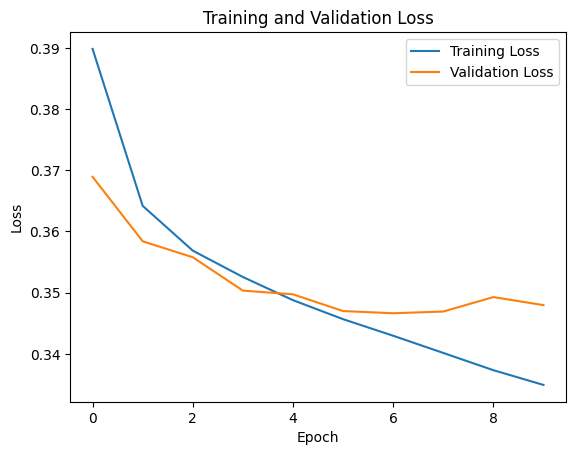

In [ ]:
plt.plot(f['loss'], label='Training Loss')
plt.plot(f['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
phenotypes = ['Acute and unspecified renal failure', 'Acute cerebrovascular disease','Acute myocardial infarction', 'Cardiac dysrhythmias',
             'Chronic kidney disease','Chronic obstructive pulmonary disease and bronchiectasis','Complications of surgical procedures or medical care',
             'Conduction disorders', 'Congestive heart failure; nonhypertensive','Coronary atherosclerosis and other heart disease','Diabetes mellitus with complications',
             'Diabetes mellitus without complication','Disorders of lipid metabolism', 'Essential hypertension','Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
             'Hypertension with complications and secondary hypertension','Other liver diseases', 'Other lower respiratory disease','Other upper respiratory disease',
             'Pleurisy; pneumothorax; pulmonary collapse','Pneumonia (except that caused by tuberculosis or sexually transmitted disease)','Respiratory failure; insufficiency; arrest (adult)',
             'Septicemia (except in labor)', 'Shock']
training_auc_score = np.array([0.83833636, 0.94334352, 0.82875869, 0.73792664, 0.83168312, 0.74654755,
                0.75166054, 0.77824187, 0.80156882, 0.82211901, 0.91360431, 0.83030576,
                0.74886739, 0.71605522, 0.77916582, 0.79989411, 0.83033734, 0.80085046,
                0.73143881, 0.82373752, 0.74294458, 0.83940944, 0.92262078, 0.87265605,
                0.91661962])
train_ave_auc_micro = 0.8522772714202943
train_ave_auc_macro = 0.8139477327475453
train_ave_auc_weighted = 0.8000233492895454

In [ ]:
phenotypes = ['Acute and unspecified renal failure', 'Acute cerebrovascular disease','Acute myocardial infarction', 'Cardiac dysrhythmias',
             'Chronic kidney disease','Chronic obstructive pulmonary disease and bronchiectasis','Complications of surgical procedures or medical care',
             'Conduction disorders', 'Congestive heart failure; nonhypertensive','Coronary atherosclerosis and other heart disease','Diabetes mellitus with complications',
             'Diabetes mellitus without complication','Disorders of lipid metabolism', 'Essential hypertension','Fluid and electrolyte disorders', 'Gastrointestinal hemorrhage',
             'Hypertension with complications and secondary hypertension','Other liver diseases', 'Other lower respiratory disease','Other upper respiratory disease',
             'Pleurisy; pneumothorax; pulmonary collapse','Pneumonia (except that caused by tuberculosis or sexually transmitted disease)','Respiratory failure; insufficiency; arrest (adult)',
             'Septicemia (except in labor)', 'Shock']
test_auc_score = [0.80775577, 0.90691603, 0.77266019, 0.69428196, 0.7739583, 0.68728797,
 0.72263082, 0.72901137, 0.75925704, 0.78926157, 0.87517894, 0.79503664,
 0.72327881, 0.67100057, 0.74527228, 0.75334639, 0.75260443, 0.7627602,
 0.68071996, 0.78506688, 0.70135227, 0.80604575, 0.90587444, 0.84522425,
 0.88202164]
test_ave_auc_micro = 0.8228723706353256
test_ave_auc_macro = 0.7731121783927264
test_ave_auc_weighted = 0.7603171711892128

CODE NOT BEING USED

In [ ]:
patient_meta_train = pd.read_csv(lfpath1)
patient_meta_test = pd.read_csv(lfpath2)
class TimeSeriesDataset(Dataset):
    def __init__(self, meta_data, directory):
        self.meta_data = meta_data
        self.directory = directory
        
    def __len__(self):
        return len(self.meta_data)
    
    def __getitem__(self, index):
        patient_id = self.meta_data.iloc[index]["stay"]
        file_path = self.directory + "/{}".format(patient_id)
        timeseries_data = pd.read_csv(file_path)
        all_variables = ['Capillary refill rate','Diastolic blood pressure','Fraction inspired oxygen','Glascow coma scale eye opening','Glascow coma scale motor response',              
                                          'Glascow coma scale total','Glascow coma scale verbal response','Glucose','Heart Rate','Height','Mean blood pressure','Oxygen saturation','Respiratory rate',              
                                          'Systolic blood pressure', 'Temperature', 'Weight', 'pH']
        categorical_variables = ['Glascow coma scale eye opening', 'Glascow coma scale motor response', 'Glascow coma scale verbal response']                               
        timeseries_data = timeseries_data.reindex(columns=all_variables)
        timeseries_data = timeseries_data.loc[:, all_variables]
        timeseries_data = timeseries_data.drop(categorical_variables, axis=1) # make sure to add back in categorical variables
        impute_dict = {'Capillary refill rate': 0.0,'Diastolic blood pressure': 59.0,'Fraction inspired oxygen': 0.21,
                       'Glascow coma scale total': 15,'Glucose': 128.0,'Heart Rate': 86,'Height': 170.0,'Mean blood pressure': 77.0,'Oxygen saturation': 98.0,
                       'Respiratory rate': 19,'Systolic blood pressure': 118.0,'Temperature': 36.6,'Weight': 81.0,'pH': 7.4}
        
        
        timeseries_data = timeseries_data.fillna(value=impute_dict)
        #median = timeseries_data.median()
        #if median.isnull().values.any():
        #  median = 0
        #timeseries_data = timeseries_data.fillna(0)
        #timeseries_data = timeseries_data.loc[:, ['Capillary refill rate','Diastolic blood pressure','Fraction inspired oxygen','pH']]
         # Normalize the timeseries_data
        
        timeseries_data = torch.tensor(timeseries_data.values, dtype=torch.float32)
        timeseries_data = F.normalize(timeseries_data, dim=0)
        if len(timeseries_data) < 75:
          padding = torch.zeros(75 - len(timeseries_data), timeseries_data.shape[1], dtype=torch.float32)
          impute_values = torch.tensor([list(impute_dict.values()) for i in range(padding.shape[0])], dtype=torch.float32)
          padding = padding + impute_values
          timeseries_data = torch.cat((padding, timeseries_data), dim=0)
        else:
          timeseries_data = timeseries_data[-75:]
        label = self.meta_data.iloc[index]["Shock"] # grabbing a specific label but remember we have 10?
        return timeseries_data, label

batch_size = 8
num_workers = 1
shuffle = True

timeseries_dataset_train = TimeSeriesDataset(patient_meta_train,"train")
timeseries_dataset_test = TimeSeriesDataset(patient_meta_test,"test")
timeseries_dataloader_train = DataLoader(timeseries_dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
timeseries_dataloader_test = DataLoader(timeseries_dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))  
        out_relu = torch.empty_like(out)
        for i in range(self.num_layers):
            out_relu[:, :, i*self.hidden_size:(i+1)*self.hidden_size] = self.relu(out[:, :, i*self.hidden_size:(i+1)*self.hidden_size])
        out = out_relu[:, -1, :]
        out = self.fc(out)
        return out


from sklearn.metrics import roc_auc_score
input_size = 14
hidden_size = 256
num_layers = 5
output_size = 1  
num_epochs = 7
drop_out = 0.2

train_losses = []
train_accuracy = []
train_auc_roc = []

test_losses = []
test_accuracy = []
test_auc_roc = []

model = LSTMModel(input_size, hidden_size, num_layers, output_size, drop_out).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_preds = []
    train_targets = []
    accumulating_train_loss = 0.0
    accumulating_train_correct = 0
    accumulating_train_total = 0

    accumulating_train_roc = 0.0
    roc_count = 0
    for i, train_batch in enumerate(timeseries_dataloader_train):

        train_batch_data = train_batch[0].to(device).float()
        train_batch_labels_1 = train_batch[1].to(device).float()
        
        optimizer.zero_grad()
        
        outputs = model(train_batch_data)
        outputs_sigmoid = torch.sigmoid(outputs)
        outputs_binary = torch.round(outputs_sigmoid)

        loss = criterion(outputs_binary[:, 0], train_batch_labels_1)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += train_batch_labels_1.size(0)
        train_correct += (outputs_binary[:, 0] == train_batch_labels_1).sum().item()

        train_preds += outputs_binary.tolist()
        train_targets += train_batch_labels_1.tolist()


        if (i+1) % (len(timeseries_dataloader_train)//20) == 0:
          print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(timeseries_dataloader_train)}, Train Loss: {train_loss/len(timeseries_dataloader_train):.4f}, Train Acc: {100*train_correct/train_total:.2f}%, Train AUC ROC Score: {roc_auc_score(train_targets, train_preds):.4f}")
          accumulating_train_loss += train_loss
          accumulating_train_correct += train_correct
          accumulating_train_total += train_total

          train_loss = 0.0
          train_correct = 0
          train_total = 0

          accumulating_train_roc += roc_auc_score(train_targets, train_preds)
          roc_count += 1

          train_targets = []
          train_preds = []

    print(f"Train Loss: {accumulating_train_loss/len(timeseries_dataloader_train):.4f}, Train Acc: {100*accumulating_train_correct/accumulating_train_total:.2f}%, Train AUC ROC Score: {100*accumulating_train_roc/roc_count:.2f}%")
    train_losses.append(accumulating_train_loss/len(timeseries_dataloader_train))
    train_accuracy.append(100*accumulating_train_correct/accumulating_train_total)
    train_auc_roc.append(100*accumulating_train_roc/roc_count)
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_preds = []
    test_targets = []

    test_roc = 0.0

    with torch.no_grad():
        for test_batch in timeseries_dataloader_test:

            test_batch_data = test_batch[0].to(device).float()
            test_batch_labels_1 = test_batch[1].to(device).float()

            outputs = model(test_batch_data)
            outputs_sigmoid = torch.sigmoid(outputs) # apply sigmoid activation to get values between 0 and 1
            outputs_binary = torch.round(outputs_sigmoid)

            loss = criterion(outputs_binary[:, 0], test_batch_labels_1) # use binary cross entropy
            test_loss += loss.item()
            
            test_total += test_batch_labels_1.size(0)
            test_correct += (outputs_binary[:, 0] == test_batch_labels_1).sum().item()
            test_preds += test_batch_labels_1.tolist()
            test_targets += test_batch_labels_1.tolist()

            test_roc += roc_auc_score(test_targets, test_preds)

    #test_roc_score =  roc_auc_score(test_targets, test_preds)
    test_losses.append(test_loss/len(timeseries_dataloader_test))
    test_accuracy.append(100*test_correct/test_total)
    train_auc_roc.append(100*test_roc/len(timeseries_dataloader_test))

    print(f"Test Loss: {test_loss/len(timeseries_dataloader_test):.4f}, Test Acc: {100*test_correct/test_total:.2f}%, , Train AUC ROC Score: {100*test_roc/len(timeseries_dataloader_test):.2f}%")
print("Training Finished")

from sklearn.metrics import roc_auc_score,accuracy_score

model.eval()
y_true = []
y_pred_nn = []
with torch.no_grad():
    for test_batch in timeseries_dataloader_test:
        test_batch_data = test_batch[0].to(device).float()
        test_batch_labels_1 = test_batch[1].to(device).float()
        outputs = model(test_batch_data)
        outputs_sigmoid = torch.sigmoid(outputs) # apply sigmoid activation to get values between 0 and 1
        outputs_rounded = torch.round(outputs_sigmoid)
        y_true.extend(test_batch_labels_1.cpu().numpy().tolist())
        y_pred_nn.extend(outputs_rounded.cpu().numpy().tolist())
roc_auc = roc_auc_score(y_true, y_pred_nn)
print('ROC AUC score: {:.4f}'.format(roc_auc))
